In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [2]:
tourney = {
    'player_index': [1,2,3,4,5],
    'round_1_wins': [2,2,0,1,2],
    'round_1_losses': [0,1,2,2,0]
}

round_2_opp_ground_truth = [3, 5, 4, 0, 2, 1]

Assigning values to wins and losses will determine the difference in performance between players. If losses should be ignored, then `loss_value = 0`. All values should be positive, even losses, as a standard. This way the final tournament score will be calculated `wins * win_value - losses * loss_value` without changing the meaning of a win and loss.

In order to ensure that the winner of the most rounds is also the winner of the overall tournament based on points, the difference between the `win_value` and `loss_value` needs to be sufficiently different. Make sure the difference between `win_value` and `loss_value` is chosen such that the following equation is greater than zero:

```
diff_between_worst_win_and_best_runnerup = (win_value * (games_per_round-1)/2 + loss_value * (games_per_round+1)/2) - number_of_rounds
```

The simplest thing to do is to choose a `loss_value` of 0.

In [3]:
win_value = 3
loss_value = 1

In [4]:
tourney_df = pd.DataFrame(data=tourney)

If there are an odd number of players in the tournament, then the linear assignment of opponents will fail. Therefore, add a dummy player, aka the "bye", to create an even number of players.

In [5]:
if len(tourney_df) % 2 == 1:
    tourney_df = tourney_df.append(pd.DataFrame([0], columns=['player_index']), sort=True)
    tourney_df['round_1_wins'] = tourney_df['round_1_wins'].fillna(0)
    tourney_df['round_1_losses'] = tourney_df['round_1_losses'].fillna(tourney_df['round_1_losses'].max())
    tourney_df = tourney_df.sort_values(by='player_index', axis=0)
    tourney_df = tourney_df.reset_index(drop=True)

In [6]:
tourney_df

,player_index,round_1_losses,round_1_wins
0,0,2.0,0.0
1,1,0.0,2.0
2,2,1.0,2.0
3,3,2.0,0.0
4,4,2.0,1.0
5,5,0.0,2.0


The diagonal must be set to a high cost to prevent self assignment. Setting the diaganol to the most losses in the tournament will ensure that there is always a player with fewer loses available for pairing.

In [7]:
win_cost_matrix = pdist(np.matrix(tourney_df['round_1_wins']).T, metric='minkowski', p=1)
win_cost_matrix = squareform(win_cost_matrix)

In [8]:
loss_cost_matrix = pdist(np.matrix(tourney_df['round_1_losses']).T, metric='minkowski', p=1)
loss_cost_matrix = squareform(loss_cost_matrix)

In [9]:
final_cost_matrix = win_value * win_cost_matrix + loss_value * loss_cost_matrix
max_cost =  np.max(final_cost_matrix)+1
np.fill_diagonal(final_cost_matrix, max_cost)

If player 1 had a bye in the first round, then they cannot have another bye.

In [10]:
bye_list = [1]

for player in bye_list:
    final_cost_matrix[0, player] = max_cost 

In [11]:
final_cost_matrix

array([[9., 9., 7., 0., 3., 8.],
       [8., 9., 1., 8., 5., 0.],
       [7., 1., 9., 7., 4., 1.],
       [0., 8., 7., 9., 3., 8.],
       [3., 5., 4., 3., 9., 5.],
       [8., 0., 1., 8., 5., 9.]])

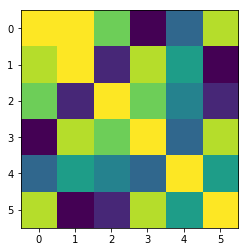

In [12]:
plt.imshow(final_cost_matrix)

In [13]:
_, col_ind = linear_sum_assignment(final_cost_matrix)

In [14]:
col_ind

array([3, 5, 4, 0, 2, 1], dtype=int64)

In [15]:
np.array_equal(round_2_opp_ground_truth, col_ind)

True